In [12]:
! pip install -q kaggle

In [13]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
! cp kaggle.json ~/.kaggle

In [15]:
! chmod 600 ~/.kaggle/kaggle.json

In [16]:
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [17]:
! kaggle datasets download histopathologic-cancer-detection

404 - Not Found


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

import zipfile 

2021-12-08 22:51:55.176382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 22:51:55.176456: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
current_path = '/home/mosobhy/machine_learning/Cancer Detection/Task 1/Histopathologic cancer detection/'
train_path = current_path + 'train_labels.csv'

train_dir = current_path + 'train/'
test_dir = current_path + 'test/'

# load the training data
train = pd.read_csv(train_path, dtype='str')
# make the label value integer
train['label'] = train['label'].astype('uint8')

# add the images extensions
train['id'] = train['id']+ '.tif'
print(len(train))
train.head(5)

220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


The image shape:  (32, 32, 3)


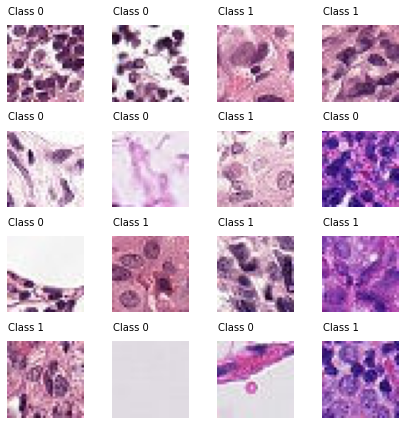

In [3]:
# view sample data
sample = train.sample(n=16).reset_index()
plt.figure(figsize=(6,6)) # specifying the overall grid size

for i, row in sample.iterrows():  
    # a (96, 96, 3) image shape
    img = mpimg.imread(f'{train_dir}{row.id}')
    label = row.label
    plt.subplot(4,4,i+1)    # the number of images in the grid is 6*6 (16)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
    plt.axis('off')

print('The image shape: ', img.shape)
plt.tight_layout()
plt.show()

In [4]:
# display the count of the two classes
print('1 classes: ', len(train[train['label'] == 1]))
print('0 classes: ', len(train[train['label'] == 0]))

# so the data is biased to the 0 class
# make a balance between these two classes
sample_size = 10000

train_0 = train[train['label'] == 0].sample(sample_size, random_state=1)
train_1 = train[train['label'] == 1].sample(sample_size, random_state=1)

# now lets merge the two classes again into the same training set
train_set = pd.concat([train_0, train_1], axis=0).reset_index(drop=True)

# shuffle the data
train = shuffle(train_set)

train['label'].value_counts()

1 classes:  89117
0 classes:  130908


0    10000
1    10000
Name: label, dtype: int64

In [7]:
train_df, valid_df = train_test_split(train, test_size=0.20, random_state=1, stratify=train.label)

print(train_df.shape)
print(valid_df.shape)

train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

BATCH_SIZE = 64

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    target_size = (96, 96),
    x_col = "id",
    y_col = "label",
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
)

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = train_dir,
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96, 96)
)

(16000, 2)
(4000, 2)
Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


# Define the sequential model

In [8]:

cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96,96,3)),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None),
    Dropout(0.25),
    BatchNormalization(),

    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None),
    Dropout(0.25),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(2, activation='softmax')
])
 

cnn_model.summary()

2021-12-08 22:54:35.937786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-08 22:54:35.937919: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-08 22:54:35.937984: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2021-12-08 22:54:35.962297: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 average_pooling2d (AverageP  (None, 48, 48, 32)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        1

In [9]:
opt = tf.keras.optimizers.Adam(0.0001)
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy',tf.keras.metrics.AUC()]
)

h1 = cnn_model.fit(
    x = train_loader,
    epochs = 30,
    validation_data = valid_loader, 
    verbose = 1
)

Epoch 1/30


2021-12-08 22:54:51.836311: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.
2021-12-08 22:54:53.334703: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.
2021-12-08 22:54:55.772993: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2021-12-08 22:54:55.903106: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.
2021-12-08 22:54:57.489628: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37748736 exceeds 10% of free system memory.


 32/250 [==>...........................] - ETA: 17:34 - loss: 0.8989 - accuracy: 0.5781 - auc: 0.5949

KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


X_train, X_test, y_train, y_test = train_test_split(
    
    X, y.reshape(-1,1) , test_size=0.10, random_state=1
)

# linear classifiers
model = None
guss_clf = GaussianNB()                             # 72%
knn_clf = KNeighborsClassifier()                   # 70%
sgd_clf = SGDClassifier(random_state=42)           # 72%
pre_clf = Perceptron()                             # 78%
dt_clf = DecisionTreeClassifier()                 # 62%
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42, max_leaf_nodes=16, n_jobs=-1)        # 85%
log_clf = LogisticRegression()
svm_clf = svm.LinearSVC()

# polynomial support vector machine classifier with 3 degrees
svm_poly_clf = svm.SVC(kernel='poly', degree=2, coef0=1, C=5)
svm_rbf_clf = svm.SVC(kernel='rbf', gamma=5, C=0.001)

# using an ensemble
ensemble_model = VotingClassifier(
    estimators=[('svc', svm_poly_clf),
                ('lr', log_clf),
                ('rf', rnd_clf),
                ('per', pre_clf)],                 # the ensemble got 80% of accurecy
    voting='hard'
)

# pipe = make_pipeline(scaler, svm_clf)            # apply the model here

# # fit the model
model = rnd_clf
model.fit(X_train, y_train.reshape(-1))
# print('accurecy: ', pipe.score(X_test, y_test) * 100, '%')
predictions = model.predict(X_test)


# Compute how well we performed
correct = (y_test.reshape(-1) == predictions).sum()
incorrect = (y_test.reshape(-1) != predictions).sum()
total = len(predictions)

# Print results
print(f"Results for model {type(model).__name__}")
print(f"Correct: {correct}")
print(f"Incorrect: {incorrect}")
print(f"Accuracy: {100 * correct / total:.2f}%")

Results for model RandomForestClassifier
Correct: 79
Incorrect: 21
Accuracy: 79.00%
